In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.linalg as la

In [2]:
#spinski operatori
def splus(v, n):
    w = copy.copy(v)
    if v==0:
        return 0
    if v[n-1] == 0:
        w[n-1] = 1
        return w
    else:
        return 0
    
def smin(v, n):
    w = copy.copy(v)
    if w == 0:
        return 0
    if w[n-1] == 1:
        w[n-1] = 0
        return w
    else:
        return 0
    
def sz(v, n, m):
    a1 = 1/2
    a2 = 1/2
    if v[n-1] == 0:
        a1 = -1/2
    if v[m-1] == 0:
        a2 = -1/2
    return a1*a2

Gore su definirani operatori podizanja i spuštanja te dvostruki operator projekcije na z os.
Ideja: prikazati vektore baze kao polja(liste) veličine 6 u koje se smještaju 1 i 0. Index polja označava ćeliju u spinskom lancu, dok 1 označava spin gore, a 0 spin dolje.

Kako radi splus(operator dizanja)?
Uzima dva parametra, vektor v, prikazan kao polje, te broj n od 1 do 6, to se odnosi na njegov index, odnosno koji spin se podiže.
Zatim gleda koja je vrijednost polja u ćeliji n te ako je 0 vraća novi, podignuti vektor, a ako je 1 vraća nulu.
Također, ako umjesto vektora v argument funkcije bude 0, vratit će nulu. Ovo je bitno jer će ponekad djelovati nakon operatora spuštanja, pa ako vektor spuštanja uništi vektor, onda on ostaje uništen i nakon ovog operatora.

Smin je operator spuštanja i radi po istom principu kao splus, samo što vraća vektor za 1 a 0 za 0.

Sz uzima tri parametra, vektor v te dva broja n i m(koji će ili biti uzastopnoi i, i+1, ili 6 i 1, zbog periodničkih uvjeta).
Zatim gleda vrijednosti ćelija n i m, te vraća 1/4 ako su iste, a -1/4 ako su različite.

In [5]:
print('primjer operatora dizanja')
splus([1,1,0,1,1,1], 3)

primjer operatora dizanja


[1, 1, 1, 1, 1, 1]

In [6]:
print('primjer operatora spuštanja')
smin([1,1,0,1,1,1], 1)

primjer operatora spuštanja


[0, 1, 0, 1, 1, 1]

In [7]:
#hamiltonijan
def ham(v):
    x = copy.copy(v)
    print('komponente 1:')
    for i in range(1, 6):
        v = x
        print(smin(splus(v, i+1), i))
    v = x
    print(smin(splus(v, 1), 6))
    
    print('komponente 2:')
    for i in range(1, 6):
        v = x
        print(splus(smin(v, i+1), i))
    v = x
    print(splus(smin(v, 1), 6))
    
    print('komponente 3:')
    for i in range(1, 6):
        v = x
        print(sz(v, i, i+1))
    v = x
    print(sz(v, 6, 1))
    

Operator ham računa vrijednost hamiltonijana za dani vektor i zatim prikaže komponente jedan(to su one gdje je s-s+), tj. vektore koji nastanu(puta -1/2 koja nije dodana), komponente 2(s+s-) te komponente 3(član koji će biti uz sam vektor v).

Koristan je kod provjere ručnog računa, no ne koristim ga u kodu jer ga se može još više automatizirati, tako da ne printa vrijednosti koje će ići u matricu nego napravi matricu.

In [8]:
def uspor(v, dim, baza):
    for i in range(0, dim):
        if(v == baza[i][:]):
            return i
    return -1
        
    
def ham2(v,dim, baza):
    x = copy.copy(v)
    sum = np.zeros(dim)
    k = 0
    for i in range(1, 6):
        v = x
        k = 0
        k = uspor(smin(splus(v, i+1), i), dim, baza)
        if(k != -1):
            sum[k] -= 0.5
    v = x
    k=0
    k= uspor(smin(splus(v, 1), 6), dim, baza)
    if(k != -1):
            sum[k] -= 0.5
            
    for i in range(1, 6):
        v = x
        k = 0
        k=uspor(splus(smin(v, i+1), i), dim, baza)
        if(k != -1):
            sum[k] -= 0.5
    v = x
    k=0
    k=uspor(splus(smin(v, 1), 6), dim, baza)
    if(k != -1):
            sum[k] -= 0.5
    
    for i in range(1, 6):
        v = x
        k = 0
        k=uspor(v, dim, baza)
        sum[k] -= sz(v, i, i+1)
        
    v = x
    k = uspor(v, dim, baza)
    sum[k] -= sz(v, 6, 1)
    return sum

Ideja je ne raditi sa cijelim prostorom dimenzije 64, nego dijeliti na manje prostore, najveći dimenzije 20.
Ti potprostori su podijeljeni tako da u jednom potprostoru su svi vektori s brojem pobuđenja $N_{up}$.
Ovo je korisno i kasnije za evoluciju sistema jer će početni vektor iz nekog potprostora ostati u tom potprostoru(fizikalno, sustav ima točno određenu energiju koja odgovara $N_{up}$ pobuđenja pa ne može napustiti potprostor).

Za svaki potprostor se generira prvo baza(objašnjenje slijedi kasnije).

Funkcija uspor(v, dim, baza) nalazi za dani vektor $v$ iz baze koji je on(po redu) vektor.
Ako vektor nije iz baze, vraća  $-1$ (moguće vrijednosti $v$ koje će funkcija primati bit će ili vektori baze ili $0$ zbog konstrukcije problema).
Pritom je dim dimenzija potprostora bitna za for petlju(govori koliko ima vektora koje treba usporediti s v)

Funkcija ham2(v, dim, baza) operativna je funkcija hamiltonijana. Prvo izgradi nul-polje sum veličine dim koje će predstavljati 
$n$-ti stupac matrice hamiltonijana ($n$ je zapravo zadan s $v$). 

Zatim odredi koji će vektor nastati kada se na $v$ djeluje s smin splus, to je vrijednost k, i ako je $k \neq -1$ pribraja $-1/2$  $k$-toj ćeliji sume sum.

Isto ponavlja za splus smin i za szsz. Na kraju vraća sum, tj prvi stupac.

Korak koji slijedi iza toga je iz stupaca iskonstruirati matricu, dijagonalizirati ju i ispisati eigenstanja.

Napomena: potprostore gdje su svi pobuđeni ili nijedan nije pobuđen riješit ću ručno na papiru zbog jednostavnosti.

In [11]:
#potprostor N_up = 5, dim = 6


#generacija baze:
d0 = np.zeros([6,6])

for i in range(0, 6):
    for j in range(0, 6):
        d0[i][j] = 1
        
red = 0

print('Baza prostora:')
for i in range(0, 6):
    d0[i][5-i] = 0
    print('b' + (str)(i+1), d0[i])  
    
d0 = d0.tolist()

Baza prostora:
b1 [1. 1. 1. 1. 1. 0.]
b2 [1. 1. 1. 1. 0. 1.]
b3 [1. 1. 1. 0. 1. 1.]
b4 [1. 1. 0. 1. 1. 1.]
b5 [1. 0. 1. 1. 1. 1.]
b6 [0. 1. 1. 1. 1. 1.]


In [12]:
H0=[]
for i in range(0, 6):
    H0.append(ham2(d0[i][:], 6, d0))
    
H0 = np.matrix.transpose(np.array(H0))
print('hamiltonijan:\n', H0, '\n\n')
rez0, v0 = la.eig(H0)

for i in range(0, 6):
    print('E' + (str)(i+1) + ':', rez0[i], '   v' + (str)(i+1) + ':', v0[:, i])

hamiltonijan:
 [[-0.5 -0.5  0.   0.   0.  -0.5]
 [-0.5 -0.5 -0.5  0.   0.   0. ]
 [ 0.  -0.5 -0.5 -0.5  0.   0. ]
 [ 0.   0.  -0.5 -0.5 -0.5  0. ]
 [ 0.   0.   0.  -0.5 -0.5 -0.5]
 [-0.5  0.   0.   0.  -0.5 -0.5]] 


E1: (0.5000000000000001+0j)    v1: [-0.40824829  0.40824829 -0.40824829  0.40824829 -0.40824829  0.40824829]
E2: (7.168080801200294e-17+0j)    v2: [ 0.57735027 -0.28867513 -0.28867513  0.57735027 -0.28867513 -0.28867513]
E3: (-1.5+0j)    v3: [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
E4: (-1.0000000000000002+0j)    v4: [ 0.57735027  0.28867513 -0.28867513 -0.57735027 -0.28867513  0.28867513]
E5: 0j    v5: [-0.12596101 -0.42497479  0.5509358  -0.12596101 -0.42497479  0.5509358 ]
E6: (-0.9999999999999998+0j)    v6: [-0.04245221 -0.51987263 -0.47742042  0.04245221  0.51987263  0.47742042]


Sve energije su zapravo u jedinicama $\tilde{J}$, dok su vektori u bazi $d0$.

In [13]:
#potprostor N_up = 4, dim = 15

#generacija baze:
d1 = np.zeros([15,6])


for i in range(0, 15):
    for j in range(0, 6):
        d1[i][j] = 1

        
red = 0

for i in range(0, 5):
    for j in range(i+1, 6):
        d1[red, j] = 0
        d1[red, i] = 0
        red+=1
    
d1 = d1.tolist()

In [14]:
for i in range(0, 15):
    print('b' + str(i+1) +':', d1[i])

b1: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
b2: [0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
b3: [0.0, 1.0, 1.0, 0.0, 1.0, 1.0]
b4: [0.0, 1.0, 1.0, 1.0, 0.0, 1.0]
b5: [0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
b6: [1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
b7: [1.0, 0.0, 1.0, 0.0, 1.0, 1.0]
b8: [1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
b9: [1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
b10: [1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
b11: [1.0, 1.0, 0.0, 1.0, 0.0, 1.0]
b12: [1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
b13: [1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
b14: [1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
b15: [1.0, 1.0, 1.0, 1.0, 0.0, 0.0]


In [15]:
H1 = []
for i in range(0, 15):
    H1.append(ham2(d1[i][:], 15, d1))
    
H1 = np.matrix.transpose(np.array(H1))
print('hamiltonijan:\n', H1, '\n\n')
rez1, v1 = la.eig(H1)


hamiltonijan:
 [[-0.5 -0.5  0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0. ]
 [-0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.  -0.5  0.   0.
   0. ]
 [ 0.  -0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.  -0.5
   0. ]
 [ 0.   0.  -0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.
  -0.5]
 [ 0.   0.   0.  -0.5 -0.5  0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0. ]
 [ 0.  -0.5  0.   0.   0.  -0.5 -0.5  0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.  -0.5  0.   0.  -0.5  0.5 -0.5  0.  -0.5  0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0.5 -0.5  0.  -0.5  0.   0.   0.
   0. ]
 [-0.5  0.   0.   0.  -0.5  0.   0.  -0.5  0.5  0.   0.  -0.5  0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.  -0.5 -0.5  0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.5 -0.5 -0.5  0.
   0. ]
 [ 0.  -0.5  0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.5  0.  -0.5
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.

In [18]:
for i in range(0, 15):
    print('E' + (str)(i+1) + ':', rez1[i], '\nv' + (str)(i+1) + ':', v1[:, i], '\n')

E1: (2.1180339887498913+0j) 
v1: [ 0.11283705 -0.29541124  0.36514837 -0.29541124  0.11283705  0.11283705
 -0.29541124  0.36514837 -0.29541124  0.11283705 -0.29541124  0.36514837
  0.11283705 -0.29541124  0.11283705] 

E2: (-1.5000000000000016+0j) 
v2: [-0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889] 

E3: (-0.500000000000001+0j) 
v3: [ 4.08248290e-01 -4.49320649e-17 -3.55129206e-16 -1.19534255e-16
 -4.08248290e-01 -4.08248290e-01 -3.03720082e-16 -9.49025056e-17
  1.68350008e-17  4.08248290e-01  1.53850896e-16 -2.90484796e-16
 -4.08248290e-01 -6.99193463e-17  4.08248290e-01] 

E4: (-0.11803398874989496+0j) 
v4: [ 0.29541124 -0.11283705 -0.36514837 -0.11283705  0.29541124  0.29541124
 -0.11283705 -0.36514837 -0.11283705  0.29541124 -0.11283705 -0.36514837
  0.29541124 -0.11283705  0.29541124] 

E5: (1.2807764064044134+0j) 
v5: [ 0.11763434 -0.20948046 -0

In [19]:
#potprostor N_up = 3, dim = 20

#generacija baze:

d2 = np.zeros([20,6])


for i in range(0, 20):
    for j in range(0, 6):
        d2[i][j] = 1

        
red = 0

for i in range(0, 4):
    for j in range(i+1, 5):
        for k in range(j+1, 6):
            d2[red, j] = 0
            d2[red, i] = 0
            d2[red, k] = 0
            red+=1
            
d2 = d2.tolist()

for i in range(0, 20):
    print('b' + str(i+1) +':', d2[i])

b1: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
b2: [0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
b3: [0.0, 0.0, 1.0, 1.0, 0.0, 1.0]
b4: [0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
b5: [0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
b6: [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
b7: [0.0, 1.0, 0.0, 1.0, 1.0, 0.0]
b8: [0.0, 1.0, 1.0, 0.0, 0.0, 1.0]
b9: [0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
b10: [0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
b11: [1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
b12: [1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
b13: [1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
b14: [1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
b15: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
b16: [1.0, 0.0, 1.0, 1.0, 0.0, 0.0]
b17: [1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
b18: [1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
b19: [1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
b20: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


In [20]:
H2 = []
for i in range(0, 20):
    H2.append(ham2(d2[i][:], 20, d2))
    
H2 = np.matrix.transpose(np.array(H2))
print('hamiltonijan:\n', H2, '\n\n')
rez2, v2 = la.eig(H2)

hamiltonijan:
 [[-0.5 -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.
   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.5 -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
  -0.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.5 -0.5  0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.
   0.  -0.5  0.   0.   0.   0. ]
 [ 0.   0.  -0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.   0.5 -0.5  0.   0.   0.   0.  -0.5  0.   0.   0.
   0.   0.   0.  -0.5  0.   0. ]
 [ 0.   0.  -0.5  0.  -0.5  1.5 -0.5 -0.5  0.   0.   0.  -0.5  0.   0.
   0.   0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -0.5  0.  -0.5  0.5  0.  -0.5  0.   0.   0.  -0.5  0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5 -0.5  0.   0.   0.   0.  -0.5
   0.   0.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   0.   0.   0.  -0.5 -0.5  0.5 -0.5  0.   0.   0.   0.
  -0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5 -

In [21]:
for i in range(0, 20):
    print('E' + (str)(i+1) + ':', rez2[i], '\nv' + (str)(i+1) + ':', v2[:, i], '\n')

E1: (2.8027756377319997+0j) 
v1: [ 0.06292062 -0.2078127   0.2078127  -0.06292062  0.2078127  -0.47854601
  0.2078127   0.2078127  -0.2078127   0.06292062 -0.06292062  0.2078127
 -0.2078127  -0.2078127   0.47854601 -0.2078127   0.06292062 -0.2078127
  0.2078127  -0.06292062] 

E2: (2.1180339887499002+0j) 
v2: [-0.0493116   0.12909944  0.12909944 -0.0493116   0.12909944 -0.62666187
  0.12909944  0.12909944  0.12909944 -0.0493116  -0.0493116   0.12909944
  0.12909944  0.12909944 -0.62666187  0.12909944 -0.0493116   0.12909944
  0.12909944 -0.0493116 ] 

E3: (-1.5000000000000009+0j) 
v3: [0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068] 

E4: (-0.1180339887498946+0j) 
v4: [ 0.33798673 -0.12909944 -0.12909944  0.33798673 -0.12909944 -0.23936353
 -0.12909944 -0.12909944 -0.12909944  0.33798673  0.33798673 -0.12909944
 -0.12909944 -0.129099

In [22]:
#potprostor N_up = 2, dim = 15

#baza:
d3 = np.zeros([15,6])
        
red = 0

for i in range(0, 5):
    for j in range(i+1, 6):
        d3[red, j] = 1
        d3[red, i] = 1
        red+=1
        
d3 = d3.tolist()
for i in range(0, 15):
    print('b' + str(i+1) +':', d3[i])

b1: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
b2: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
b3: [1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
b4: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
b5: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
b6: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
b7: [0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
b8: [0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
b9: [0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
b10: [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
b11: [0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
b12: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
b13: [0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
b14: [0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
b15: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0]


In [23]:
H3 = []
for i in range(0, 15):
    H3.append(ham2(d3[i], 15, d3))
    
H3 = np.matrix.transpose(np.array(H3))
print('hamiltonijan:\n', H3, '\n\n')
rez3, v3 = la.eig(H3)

hamiltonijan:
 [[-0.5 -0.5  0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0. ]
 [-0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.  -0.5  0.   0.
   0. ]
 [ 0.  -0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.  -0.5
   0. ]
 [ 0.   0.  -0.5  0.5 -0.5  0.   0.  -0.5  0.   0.   0.   0.   0.   0.
  -0.5]
 [ 0.   0.   0.  -0.5 -0.5  0.   0.   0.  -0.5  0.   0.   0.   0.   0.
   0. ]
 [ 0.  -0.5  0.   0.   0.  -0.5 -0.5  0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.  -0.5  0.   0.  -0.5  0.5 -0.5  0.  -0.5  0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.  -0.5  0.   0.  -0.5  0.5 -0.5  0.  -0.5  0.   0.   0.
   0. ]
 [-0.5  0.   0.   0.  -0.5  0.   0.  -0.5  0.5  0.   0.  -0.5  0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.  -0.5 -0.5  0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.5 -0.5 -0.5  0.
   0. ]
 [ 0.  -0.5  0.   0.   0.   0.   0.   0.  -0.5  0.  -0.5  0.5  0.  -0.5
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.

In [24]:
for i in range(0, 15):
    print('E' + (str)(i+1) + ':', rez3[i], '\nv' + (str)(i+1) + ':', v3[:, i], '\n')

E1: (2.1180339887498913+0j) 
v1: [ 0.11283705 -0.29541124  0.36514837 -0.29541124  0.11283705  0.11283705
 -0.29541124  0.36514837 -0.29541124  0.11283705 -0.29541124  0.36514837
  0.11283705 -0.29541124  0.11283705] 

E2: (-1.5000000000000016+0j) 
v2: [-0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889 -0.25819889
 -0.25819889 -0.25819889 -0.25819889] 

E3: (-0.500000000000001+0j) 
v3: [ 4.08248290e-01 -4.49320649e-17 -3.55129206e-16 -1.19534255e-16
 -4.08248290e-01 -4.08248290e-01 -3.03720082e-16 -9.49025056e-17
  1.68350008e-17  4.08248290e-01  1.53850896e-16 -2.90484796e-16
 -4.08248290e-01 -6.99193463e-17  4.08248290e-01] 

E4: (-0.11803398874989496+0j) 
v4: [ 0.29541124 -0.11283705 -0.36514837 -0.11283705  0.29541124  0.29541124
 -0.11283705 -0.36514837 -0.11283705  0.29541124 -0.11283705 -0.36514837
  0.29541124 -0.11283705  0.29541124] 

E5: (1.2807764064044134+0j) 
v5: [ 0.11763434 -0.20948046 -0

In [25]:
#potprostor N_up = 1, dim = 6

#baza:
d4 = np.zeros([6,6])

for i in range(0, 6):
    for j in range(0, 6):
        if d0[i][j] == 1:
            d4[i][j] = 0
        else:
            d4[i][j] = 1
            
d4 = d4.tolist()

for i in range(0, 6):
    print('b' + str(i+1) +':', d4[i])

b1: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
b2: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
b3: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
b4: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
b5: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
b6: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [26]:
H4 = []

for i in range(0, 6):
    H4.append(ham2(d4[i], 6, d4))
    
H4 = np.matrix.transpose(np.array(H4))
print('hamiltonijan:\n', H4, '\n\n')
rez4, v4 = la.eig(H4)

hamiltonijan:
 [[-0.5 -0.5  0.   0.   0.  -0.5]
 [-0.5 -0.5 -0.5  0.   0.   0. ]
 [ 0.  -0.5 -0.5 -0.5  0.   0. ]
 [ 0.   0.  -0.5 -0.5 -0.5  0. ]
 [ 0.   0.   0.  -0.5 -0.5 -0.5]
 [-0.5  0.   0.   0.  -0.5 -0.5]] 




In [27]:
for i in range(0, 6):
    print('E' + (str)(i+1) + ':', rez4[i], '   v' + (str)(i+1) + ':', v4[:, i])

E1: (0.5000000000000001+0j)    v1: [-0.40824829  0.40824829 -0.40824829  0.40824829 -0.40824829  0.40824829]
E2: (7.168080801200294e-17+0j)    v2: [ 0.57735027 -0.28867513 -0.28867513  0.57735027 -0.28867513 -0.28867513]
E3: (-1.5+0j)    v3: [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
E4: (-1.0000000000000002+0j)    v4: [ 0.57735027  0.28867513 -0.28867513 -0.57735027 -0.28867513  0.28867513]
E5: 0j    v5: [-0.12596101 -0.42497479  0.5509358  -0.12596101 -0.42497479  0.5509358 ]
E6: (-0.9999999999999998+0j)    v6: [-0.04245221 -0.51987263 -0.47742042  0.04245221  0.51987263  0.47742042]


In [28]:
#prostor N_up = 6:
print('E =', -3/2, ', v =', [1,1,1,1,1,1])

E = -1.5 , v = [1, 1, 1, 1, 1, 1]


In [29]:
#prostor N_up = 0:
print('E =', -3/2, ', v =', [0,0,0,0,0,0])

E = -1.5 , v = [0, 0, 0, 0, 0, 0]


Napomena: generacija baze

Baze se generiraju kombinatoričkim pristupom.

Ideja(za primjer 6 spinova, 2 pobuđenja):

Sve se baze popune s nulama, zatim se u prvi vektor stavi $1$ na prvo mjesto i $1$ na drugo. Druga jedinica se zatim pomiče za daljnje vektore dok ne dođe do kraja polja. Kada dođe, onda prva jedinica ide u drugu ćeliju a druga u treću i opet se pomiče i tako dok se ne popuni cijela baza.

In [30]:
#drugi podzadatak:
fi0 = [0,1,0,0,0,0]  #ovo je b5, index 4

#baza:
for i in range(0, 6):
    print('b' + str(i+1) +':', d4[i])
    
#sv.vektori su v4, energije rez4
for i in range(0, 6):
    print('v' + str(i+1) +':', v4[:,i])

c = []

J = 1.3 #potrebno je definirati zbog evolucije sistema, naći će se u brojniku eksponenta
tmesh = np.arange(0, 10, 0.05)


b1: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
b2: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
b3: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
b4: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
b5: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
b6: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
v1: [-0.40824829  0.40824829 -0.40824829  0.40824829 -0.40824829  0.40824829]
v2: [ 0.57735027 -0.28867513 -0.28867513  0.57735027 -0.28867513 -0.28867513]
v3: [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
v4: [ 0.57735027  0.28867513 -0.28867513 -0.57735027 -0.28867513  0.28867513]
v5: [-0.12596101 -0.42497479  0.5509358  -0.12596101 -0.42497479  0.5509358 ]
v6: [-0.04245221 -0.51987263 -0.47742042  0.04245221  0.51987263  0.47742042]


In [31]:
c = []
M = np.zeros([6,6])
fi0 = np.array(fi0)
for i in range(0, 6):
    for j in range(0, 6):
        M[j][i] = v4[j, i]
c = la.solve(M, fi0)
M

array([[-0.40824829,  0.57735027,  0.40824829,  0.57735027, -0.12596101,
        -0.04245221],
       [ 0.40824829, -0.28867513,  0.40824829,  0.28867513, -0.42497479,
        -0.51987263],
       [-0.40824829, -0.28867513,  0.40824829, -0.28867513,  0.5509358 ,
        -0.47742042],
       [ 0.40824829,  0.57735027,  0.40824829, -0.57735027, -0.12596101,
         0.04245221],
       [-0.40824829, -0.28867513,  0.40824829, -0.28867513, -0.42497479,
         0.51987263],
       [ 0.40824829, -0.28867513,  0.40824829,  0.28867513,  0.5509358 ,
         0.47742042]])

In [32]:
A1 = []
A2 = []
A3 = []
A4 = []
A5 = []
A6 = []

for t in tmesh:
    C = []
    A = 0
    for i in range(0, 6):
        C.append(c[i]*np.exp(-1j*t*rez4[i]*J))
    for i in range(0, 6):
        A += C[i]*v4[0, i]
    A1.append(A)
    A = 0
    for i in range(0, 6):
        A += C[i]*v4[1, i]
    A2.append(A)
    A = 0
    for i in range(0, 6):
        A += C[i]*v4[2, i]
    A3.append(A)
    A = 0
    for i in range(0, 6):
        A += C[i]*v4[3, i]
    A4.append(A)
    A = 0
    for i in range(0, 6):
        A += C[i]*v4[4, i]
    A5.append(A)
    A = 0
    for i in range(0, 6):
        A += C[i]*v4[5, i]
    A6.append(A)

Text(0.5, 0, 'vrijeme')

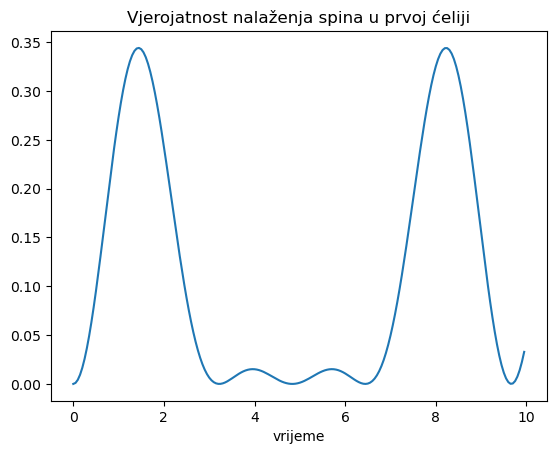

In [33]:
plt.plot(tmesh, np.abs(np.array(A1))**2)
plt.title('Vjerojatnost nalaženja spina u prvoj ćeliji')
plt.xlabel('vrijeme')

Text(0.5, 0, 'vrijeme')

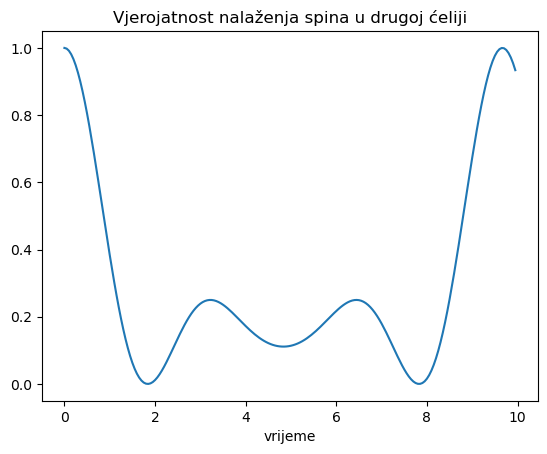

In [34]:
plt.plot(tmesh, np.abs(np.array(A2))**2)
plt.title('Vjerojatnost nalaženja spina u drugoj ćeliji')
plt.xlabel('vrijeme')

Text(0.5, 0, 'vrijeme')

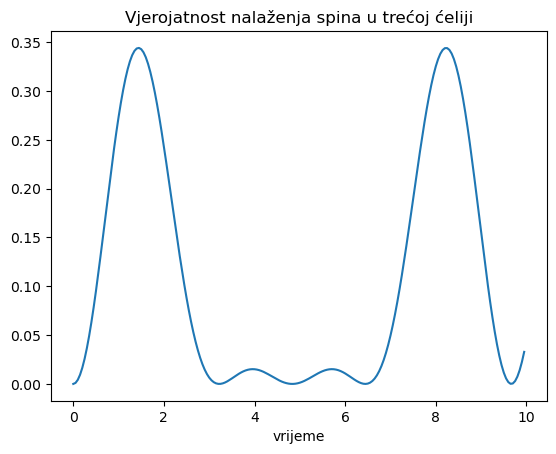

In [35]:
plt.plot(tmesh, np.abs(np.array(A3))**2)
plt.title('Vjerojatnost nalaženja spina u trećoj ćeliji')
plt.xlabel('vrijeme')

Text(0.5, 0, 'vrijeme')

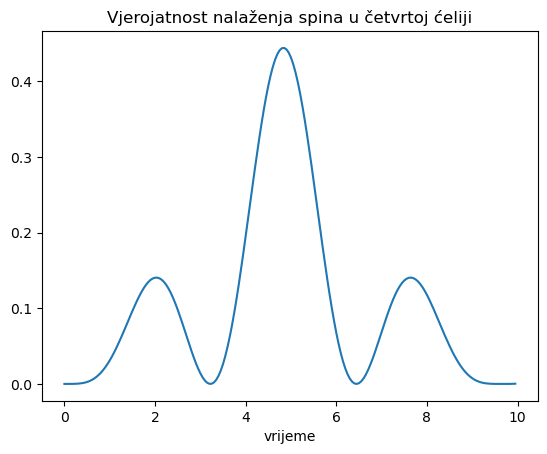

In [36]:
plt.plot(tmesh, np.abs(np.array(A4))**2)
plt.title('Vjerojatnost nalaženja spina u četvrtoj ćeliji')
plt.xlabel('vrijeme')

Text(0.5, 0, 'vrijeme')

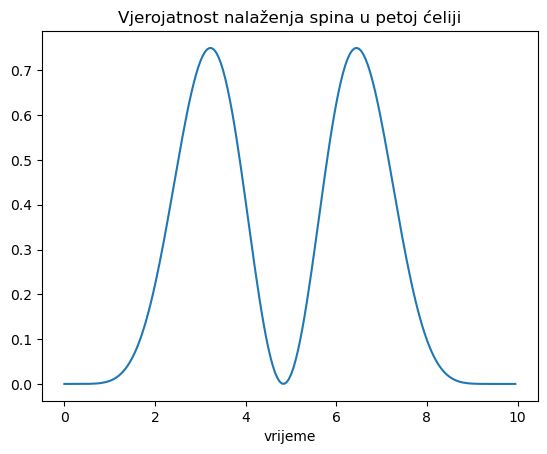

In [37]:
plt.plot(tmesh, np.abs(np.array(A5))**2)
plt.title('Vjerojatnost nalaženja spina u petoj ćeliji')
plt.xlabel('vrijeme')

Text(0.5, 0, 'vrijeme')

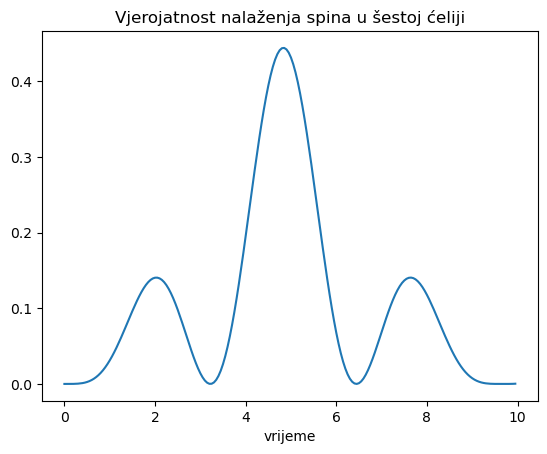

In [38]:
plt.plot(tmesh, np.abs(np.array(A6))**2)
plt.title('Vjerojatnost nalaženja spina u šestoj ćeliji')
plt.xlabel('vrijeme')

(0.0, 5.0)

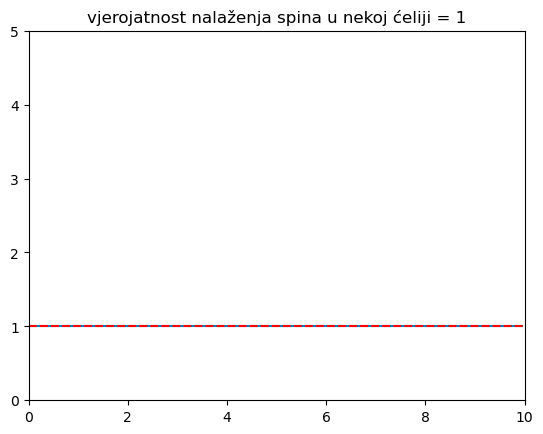

In [39]:
A = 0
A += np.abs(np.array(A6))**2
A += np.abs(np.array(A5))**2
A += np.abs(np.array(A4))**2
A += np.abs(np.array(A3))**2
A += np.abs(np.array(A2))**2
A += np.abs(np.array(A1))**2
plt.plot(tmesh, A)
plt.axhline(y = 1, ls='--', color = 'red')
plt.title('vjerojatnost nalaženja spina u nekoj ćeliji = 1')
plt.xlim(0, 10)
plt.ylim(0, 5)